# Load Libraries

In [1]:
# basic
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

work_dir = '/lustre/work/akira.tokiwa/LensingSSC'

sys.path.append(work_dir+'/lib')
sys.path.append(work_dir+'/src')

In [2]:
from astropy import cosmology
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

# Initialize cosmology model
chi = 5000
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.309)
z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
print(z)

1.7980456025637581


In [3]:
from src.utils.ConfigData import ConfigData, CatalogHandler
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config = ConfigData.from_json(config_file)
cath_tiled = CatalogHandler(config.tileddir, config.source, config.dataset)
cath_bigbox = CatalogHandler(config.bigboxdir, config.source, config.dataset)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


# Kappa maps

In [4]:
# load base kappa
path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/data/kappa_zs0.5.fits'

# read the data
kappa_nested = hp.read_map(path) # in nested ordering
kappa = hp.reorder(kappa_nested, n2r=True) # convert to ring ordering

In [5]:
smoothed_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/smoothed/kappa_zs0.5_smoothed_s10.fits'

# read the smoothed map
kappa_smoothed = hp.read_map(smoothed_path)
kappa_smoothed_nested = hp.reorder(kappa_smoothed, r2n=True)

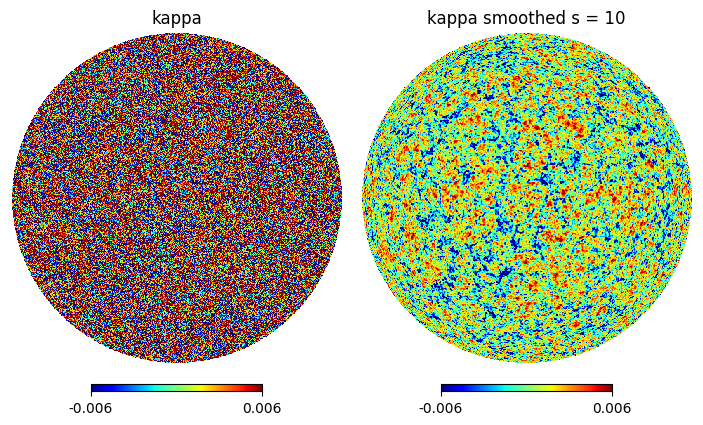

In [6]:
# plot the data
fig = plt.figure(figsize=(7, 4))
hp.orthview(kappa, title='kappa', sub=(1, 2, 1), min=-0.006, max=0.006, cmap='jet', half_sky=True)
hp.orthview(kappa_smoothed, title='kappa smoothed s = 10', sub=(1, 2, 2), min=-0.006, max=0.006, cmap='jet', half_sky=True)
plt.show()

In [7]:
noise_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/noise/noise_Roman_seed100.fits'
noisy_smoothed_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/smoothed/sl=10/kappa_zs0.5_smoothed_sl10_noise_Roman_seed100.fits'

kappa_noise = hp.read_map(noise_path)
kappa_noisy_smoothed = hp.read_map(noisy_smoothed_path)

# Full Sky

## PDF

In [11]:
def run_PDF(map1_smooth, fname, dir_results='/lustre/work/akira.tokiwa/Projects/LensingSSC/results/test'):    
        dir_PDF = os.path.join(dir_results, 'PDF')
        os.makedirs(dir_PDF, exist_ok=True)
        fn_out_counts = os.path.basename(fname).replace('.fits', '_Counts_kappa_width0.1_200Kappabins.dat')

        if os.path.exists(os.path.join(dir_PDF, fn_out_counts)):
            counts_smooth = np.loadtxt(os.path.join(dir_PDF, fn_out_counts))
        else:
                # Calculate histogram
                bins = np.linspace(-0.1 - 0.001, 0.1 + 0.001, 201)
                counts_smooth, _ = np.histogram(map1_smooth, density=True, bins=bins)
                np.savetxt(os.path.join(dir_PDF, fn_out_counts), counts_smooth)
        return counts_smooth, os.path.join(dir_PDF, fn_out_counts)

In [12]:
def plot_PDF(data_file, fname, dir_img='/lustre/work/akira.tokiwa/Projects/LensingSSC/img/test'):
    # Plot the PDF
    bins = np.linspace(-0.1, 0.1, 200)
    counts = np.loadtxt(data_file)
    plt.figure(figsize=(7, 4))
    plt.plot(bins, counts, drawstyle='steps-post')
    plt.xlabel('Kappa')
    plt.ylabel('Probability Density')

    dataname = os.path.basename(fname).replace('.fits', '')
    plt.title(f'PDF of {dataname}')
    plt.grid(True)

    # Save the figure
    output_file = os.path.basename(fname).replace('.fits', '_PDF.png')
    plt.savefig(os.path.join(dir_img, output_file), bbox_inches='tight')

    # Show the plot
    plt.show()

In [13]:
base_PDF, base_PDF_path = run_PDF(kappa, path)
smoothed_PDF, smoothed_PDF_path = run_PDF(kappa_smoothed, smoothed_path)
noisy_PDF, noisy_PDF_path = run_PDF(kappa_noisy, noisy_path)

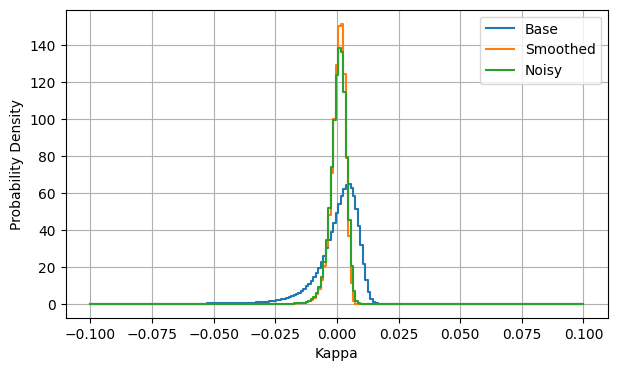

In [16]:
bins = np.linspace(-0.1, 0.1, 200)
plt.figure(figsize=(7, 4))
plt.plot(bins, base_PDF, drawstyle='steps-post', label='Base')
plt.plot(bins, smoothed_PDF, drawstyle='steps-post', label='Smoothed')
plt.plot(bins, noisy_PDF, drawstyle='steps-post', label='Noisy')
plt.xlabel('Kappa')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


# Flatsky

## Peaks Minima

In [21]:
center_ra = 0
center_dec = 0
patch_size_deg = 10

patch = hp.gnomview(kappa, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)
patch_smoothed = hp.gnomview(kappa_smoothed, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)
patch_noisy = hp.gnomview(kappa_noisy, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)

In [118]:
from astropy import units as u
from lenstools import ConvergenceMap

def calculate_peaks_minima(patch, angle, peak_bins, minima_bins, return_index=True):
    conv_map = ConvergenceMap(patch, angle=angle * u.deg)
    peak_height,peak_positions = conv_map.locatePeaks(peak_bins)
    peak_height,peak_positions = exclude_edges(peak_height, peak_positions, angle, patch.shape[0], return_index=return_index)

    conv_map_minus = ConvergenceMap(-patch, angle=angle * u.deg)
    minima_height,minima_positions = conv_map_minus.locatePeaks(minima_bins)
    minima_height = -minima_height

    minima_height,minima_positions = exclude_edges(minima_height, minima_positions, angle, patch.shape[0], return_index=return_index)

    print("Identified peaks: ", len(peak_positions), "Identified minima: ", len(minima_positions))

    return peak_height, peak_positions, minima_height, minima_positions

def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]

In [119]:
peak_bins = np.append(np.append(-1, np.arange(0, 0.024, 0.002)), 1)
minima_bins = np.append(np.append(-1, np.arange(-0.024, 0, 0.002)), 1)

peak_height, peak_positions, minima_height, minima_positions = calculate_peaks_minima(patch, patch_size_deg, peak_bins, minima_bins)
peak_height_smoothed, peak_positions_smoothed, minima_height_smoothed, minima_positions_smoothed = calculate_peaks_minima(patch_smoothed, patch_size_deg, peak_bins, minima_bins)
peak_height_noisy, peak_positions_noisy, minima_height_noisy, minima_positions_noisy = calculate_peaks_minima(patch_noisy, patch_size_deg, peak_bins, minima_bins)

Identified peaks:  98626 Identified minima:  97276
Identified peaks:  104 Identified minima:  115
Identified peaks:  129 Identified minima:  131


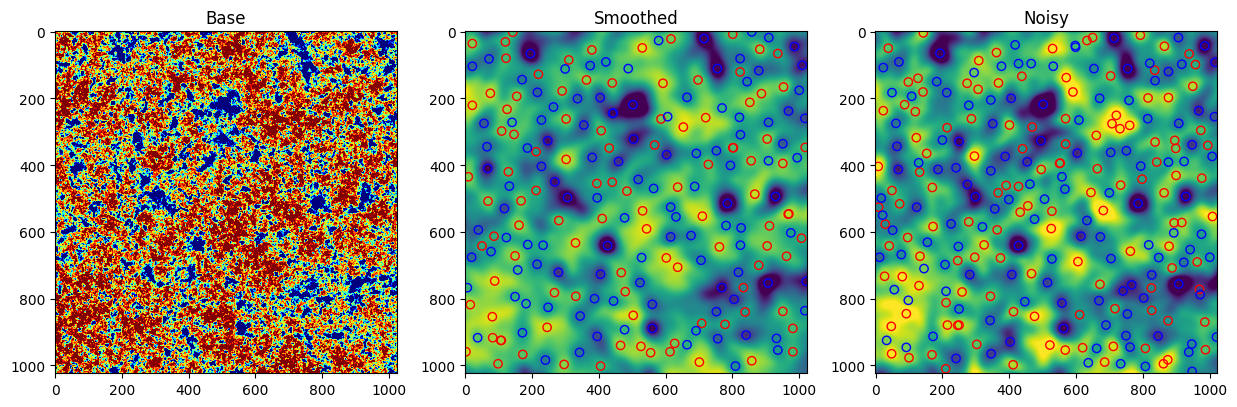

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(patch, cmap='jet', vmin=-0.006, vmax=0.006)
ax[0].set_title('Base')

ax[1].imshow(patch_smoothed, cmap='viridis', vmin=-0.006, vmax=0.006)
ax[1].scatter(peak_positions_smoothed[:, 0], peak_positions_smoothed[:, 1], facecolors='none', edgecolors='red', label='Peaks')
ax[1].scatter(minima_positions_smoothed[:, 0], minima_positions_smoothed[:, 1], facecolors='none', edgecolors='blue', label='Minima')
ax[1].set_title('Smoothed')

ax[2].imshow(patch_noisy, cmap='viridis', vmin=-0.006, vmax=0.006)
ax[2].scatter(peak_positions_noisy[:, 0], peak_positions_noisy[:, 1], facecolors='none', edgecolors='red', label='Peaks')
ax[2].scatter(minima_positions_noisy[:, 0], minima_positions_noisy[:, 1], facecolors='none', edgecolors='blue', label='Minima')
ax[2].set_title('Noisy')

plt.show()